In [1]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: data/BBC News Summary/
  inflating: data/BBC News Summary/.DS_Store  
   creating: data/BBC News Summary/News Articles/
  inflating: data/BBC News Summary/News Articles/.DS_Store  
   creating: data/BBC News Summary/News Articles/entertainment/
  inflating: data/BBC News Summary/News Articles/entertainment/289.txt  
  inflating: data/BBC News Summary/News Articles/entertainment/262.txt  
  inflating: data/BBC News Summary/News Articles/entertainment/276.txt  
  inflating: data/BBC News Summary/News Articles/entertainment/060.txt  
  inflating: data/BBC News Summary/News Articles/entertainment/074.txt  
  inflating: data/BBC News Summary/News Articles/entertainment/048.txt  
  inflating: data/BBC News Summary/News Articles/entertainment/114.txt  
  inflating: data/BBC News Summary/News Articles/entertainment/100.txt  
  inflating: data/BBC News Summary/News Articles/entertainment/128.txt  
  inflati

In [2]:
pip -q install sumy numpy seaborn pandas nltk tensorflow-gpu torch matplotlib transformers Iprogress sentencepiece

     |████████████████████████████████| 97 kB 1.2 MB/s 
     |████████████████████████████████| 588.3 MB 19 kB/s 
     |████████████████████████████████| 5.8 MB 48.7 MB/s 
     |████████████████████████████████| 1.3 MB 58.9 MB/s 
     |████████████████████████████████| 10.1 MB 54.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 439 kB 72.2 MB/s 
     |████████████████████████████████| 1.7 MB 52.6 MB/s 
     |████████████████████████████████| 6.0 MB 27.2 MB/s 
     |████████████████████████████████| 7.6 MB 46.2 MB/s 
     |████████████████████████████████| 182 kB 67.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.12.6 which is incompatible.
tensorflow 2.9.2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random

## BBC News Summary EDA
TODO: add general description here

### Data preperation
To get started please paste the BBC news dataset into a folder titled data in the local directory. Then delete 199.txt in the articles and summaries directory respectively due to corruption with these files.

In [4]:
def get_text_by_topic(directory_path):
    data = []
    count = 0
    for topic in os.listdir(directory_path):
        topic_path = os.path.join(directory_path, topic)
        if not os.path.isdir(topic_path):
          continue
        for file_path in os.listdir(topic_path):
            try:
                with open(f'{topic_path}/{file_path}', 'r', encoding="utf-8") as f:
                    data.append(( topic_path.split('/')[-1],f.read()))
                count+=1
            except UnicodeDecodeError:
                print(f'file {file_path} in {topic_path} is not readable')
                print(UnicodeDecodeError)
    df = pd.DataFrame(data, columns=['label','text'])
    print(f"Total Items loaded: {count}")
    return df
                      
articles_path = r"data/BBC News Summary/News Articles"
summaries_path = r"data/BBC News Summary/Summaries"

articles_df = get_text_by_topic(articles_path)
summaries_df = get_text_by_topic(summaries_path)
articles_df.head()

file .DS_Store in data/BBC News Summary/News Articles/sport is not readable
<class 'UnicodeDecodeError'>
Total Items loaded: 2224
file .DS_Store in data/BBC News Summary/Summaries/sport is not readable
<class 'UnicodeDecodeError'>
Total Items loaded: 2224


,label,text
0,entertainment,Rock band U2 break ticket record\n\nU2 have sm...
1,entertainment,Celebrities get to stay in jungle\n\nAll four ...
2,entertainment,Stars shine on Bafta red carpet\n\nHollywood s...
3,entertainment,Artists' secret postcards on sale\n\nPostcards...
4,entertainment,Spirit awards hail Sideways\n\nThe comedy Side...


### Lets see an example from the dataset

In [5]:
print("Articles Shape: ",articles_df.shape)
print("Summaries Shape: ",summaries_df.shape)
# If this fails the wrong number of aricles or summaries was loaded
assert(articles_df.shape == summaries_df.shape)

ex_idx = int(random.random()*articles_df.shape[0])
ex_topic = articles_df["label"][ex_idx]
print(f"\nRandom Example Article in {ex_topic}:")
print(articles_df["text"][ex_idx])
print(f"Random Example Summary in {ex_topic}:")
print(summaries_df["text"][ex_idx])

Articles Shape:  (2224, 2)
Summaries Shape:  (2224, 2)

Random Example Article in business:
Economy 'strong' in election year

UK businesses are set to prosper during the next few months - but this could trigger more interest rate rises, according to a report.

Optimism is at its highest since 1997 and business will reap the benefits of a continuing rise in public spending, say researchers at BDO Stoy Hayward. The Bank of England is expected to keep rates on hold this week - but they could go up later in the year. Rates are likely to rise after the anticipated general election in May. The BDO optimism index - a leading indicator of GDP growth two quarters ahead edged up in January to 102.5, from 102.2 in October. The rise is due, in part, to an increase in public spending and increased merger and acquisition activity.

The only thing blighting business optimism this year will be uncertainties associated with the general election, BDO said. Its BDO's output index - which predicts GDP mo

From this example we can see the dataset consists of BBC articles and co-responding summaries that are constructed in an extractive manner, that is, each summary is constructed by selecting a subset of the sentances in the original article.

In [6]:
# Null Checks
articles_df.isna().sum()
summaries_df.isna().sum()

label    0
text     0
dtype: int64

Next looking into the balance of each topic in the dataset

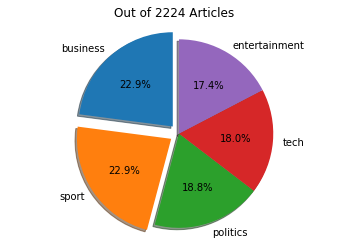

In [7]:
# Percent articles in each topic
label_vals = articles_df["label"].value_counts()

labels = list(label_vals.keys())
sizes = list(label_vals)
explode = [0]*len(sizes) 
explode[0] =0.1
explode[1] =0.1
fig1, ax1 = plt.subplots()
ax1.pie(label_vals, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f"Out of {articles_df.shape[0]} Articles")
plt.show()


The classes appear to be well balance so model performance should be equivelent across topics

99th percentile in sentance count:  63.0


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


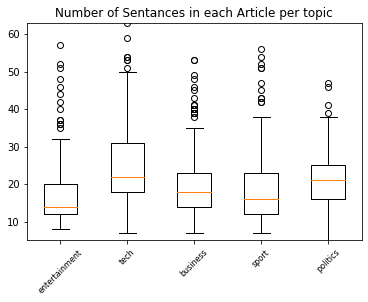

,entertainment,tech,business,sport,politics
count,386.000000,401.000000,510.000000,510.000000,417.000000
mean,17.945596,25.842893,19.680392,18.280392,22.227818
std,14.270836,12.904370,7.409560,9.876736,15.467658
min,8.000000,7.000000,7.000000,7.000000,5.000000
25%,12.000000,18.000000,14.000000,12.000000,16.000000
50%,14.000000,22.000000,18.000000,16.000000,21.000000
75%,20.000000,31.000000,23.000000,23.000000,25.000000
max,205.000000,161.000000,53.000000,82.000000,246.000000


In [8]:
# Number of Sentances in articles per topic
def get_text_length(daf, split):
    text_lens = [[len(t.split(split)) for t in daf["text"][daf['label'] == label]] for label in daf['label'].unique()]
    return text_lens

# Splitting on . for each sentance
text_lens = get_text_length(articles_df, ".")

t_lengths = pd.DataFrame(text_lens).transpose()
t_lengths.columns = articles_df['label'].unique()

# Outliars
print("99th percentile in sentance count: ",np.max(t_lengths.quantile(0.99)))

plt.boxplot(text_lens)
plt.title('Number of Sentances in each Article per topic')
plt.ylim(np.min(t_lengths.quantile(0)), np.max(t_lengths.quantile(0.99)))
plt.xticks([1,2,3,4,5],articles_df['label'].unique(),
                    rotation=45, fontsize=8)
plt.show()
t_lengths.describe()

It appears that tech articles have the longest articles in terms of sentances however the categories seem to be balanced here aswell. Noteably there are some drastic outliars for article length with 200+ sentances that may have to be removed.

99th percentile in Word count:  475.0


/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


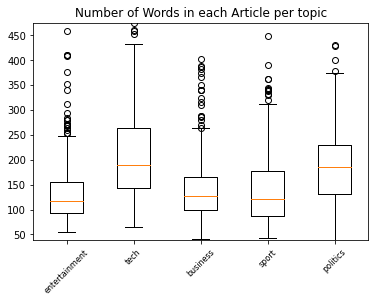

,entertainment,tech,business,sport,politics
count,386.00000,401.000000,510.00000,510.000000,417.000000
mean,144.07772,213.880299,139.94902,143.194118,195.738609
std,124.31821,111.675336,59.48480,80.966871,139.855957
min,54.00000,65.000000,40.00000,42.000000,38.000000
25%,93.25000,144.000000,99.00000,87.000000,132.000000
50%,117.00000,189.000000,127.00000,122.000000,186.000000
75%,154.75000,264.000000,164.75000,178.500000,230.000000
max,1708.00000,1433.000000,403.00000,659.000000,2074.000000


In [9]:
# Number of Words in articles per topic (splitting on " ")
text_lens = get_text_length(summaries_df, " ")

t_lengths = pd.DataFrame(text_lens).transpose()
t_lengths.columns = articles_df['label'].unique()

# Outliars
print("99th percentile in Word count: ",np.max(t_lengths.quantile(0.99)))

plt.boxplot(text_lens)
plt.title('Number of Words in each Article per topic')
plt.ylim(np.min(t_lengths.quantile(0)), np.max(t_lengths.quantile(0.99)))
plt.xticks([1,2,3,4,5],articles_df['label'].unique(),
                    rotation=45, fontsize=8)
plt.show()
t_lengths.describe()

Comparing the word counts to the sentance counts we can see the same outliar issue exists as well as sports having less words despite having more sentances implying that sentance length will vary based on the topic.

### Next looking at the ground truth reduction in word count

In [10]:
# Summary length reduction per topic by word count
articles_len = get_text_length(articles_df, " ")
summaries_len = get_text_length(summaries_df, " ")


# For each Topic
print("Average percent reduction in words for ...")
for i,topic in enumerate(articles_df['label'].unique()):
    # 1  - ratio of summary to article length
    avg_percent_reduction = np.mean(1-np.asarray(summaries_len[i])/np.asarray(articles_len[i]))
    print(f"{topic} summaries: {100*avg_percent_reduction:0.4f}%")

Average percent reduction in words for ...
entertainment summaries: 56.0781%
tech summaries: 57.2868%
business summaries: 56.8027%
sport summaries: 55.5133%
politics summaries: 56.5632%


From this we see across the board roughly half of the words are dropped in the ground truth summaries implying our model should have a similar dropout rate. This also may indicate classification may be a valid approach to determining whether a sentance should remain in the summary. Running this code over with sentance count reveals a similar trend implying no relationship between sentance length and likelyhood to be in the summmary.

### EDA with common heuristics in NLP

In extractive text summarization a common baseline model is to simply take the first few sentances (typically 3) of a peice of text as the summary as writers often introduce their main points in the beggining of articles. We will analyze the effectiveness of this heuristic for the BBC model for possible consideration for a baseline model

In [11]:
# For regular expression
import re
# for sentance parsing
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# turn each article into a list of sentances
def get_sentances(texts_list):
    documents = []
    for text in texts_list:
        documents.append(sent_tokenize(text.replace("\n\n",". ").replace(".. ",". ").replace(".",". ").replace(".  ",". ")))
    return documents
    #return [[a.strip() for a in t.replace("\n\n",".").split(".") if a!=''] for t in texts_list]

# First sentance inclusion in summary
article_sentances = get_sentances(articles_df["text"])
summary_sentances = get_sentances(summaries_df["text"])

# Check how many sentances (up to the fourth) of the article are in the summary
counts = [0]*4
for a,s in zip(article_sentances,summary_sentances):
    for i in range(len(counts)):
        if a[i+1] in s:
            counts[i]+=1
        else:
            break
print(f"{100*counts[0]/len(article_sentances):0.2f}% Article summaries include the first sentance of the article")
print(f"{100*counts[1]/len(article_sentances):0.2f}% Article summaries include the first and second")
print(f"{100*counts[2]/len(article_sentances):0.2f}% Article summaries include the first, second, and third")
print(f"{100*counts[3]/len(article_sentances):0.2f}% Article summaries include the first, second, third and fourth")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


69.83% Article summaries include the first sentance of the article
36.29% Article summaries include the first and second
17.81% Article summaries include the first, second, and third
7.33% Article summaries include the first, second, third and fourth


From this a good baseline model to compare text summarization would simply be to use the first few sentances of each article as the summary. The performance of this method is best with including one to two sentances

In [12]:
# Rarity of words used

In [13]:
# Overall use of stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Most common words after stop words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
# Additional NLP statistics

## Base Line Model
From the EDA we found that an effective baseline model would be taking the first two sentances of the article as the predicted summary

In [15]:
# Each base line prediction is the first two sentaces of the article
def base_line_predict(articles_df):
    predictions = []
    article_sentances = get_sentances(articles_df["text"])
    for a in article_sentances:
        predictions.append(a[1:3])
    return predictions

pred = base_line_predict(articles_df)
print(f"Example baseline: {pred[0]}\n")
print(f"Example summary: {summary_sentances[0]}")

Example baseline: ['U2 have smashed Irish box office records with ticket sales for their Dublin concerts, after more than 150,000 were sold within 50 minutes.', "Tickets for the two concerts at the city's Croke Park stadium were released at 8am on Friday morning."]

Example summary: ['"We could have sold a million tickets.', '"U2 have smashed Irish box office records with ticket sales for their Dublin concerts, after more than 150,000 were sold within 50 minutes.', 'Mr Green said that ticket outlets had been "bombarded" by U2 fans.', 'However the majority of tickets, priced at between 59.', '50 and 80 euro each, were sold online.', 'Earlier this week, Bono announced that the band would play two shows at the venue, which holds almost 80,000 people, due to the phenomenal demand for tickets.']


## Preprocessing For Extractive Text Summarization

In [16]:
from nltk.tokenize import word_tokenize
def compare_sentances(sentance_a, sentance_b):
    tok_a = word_tokenize(sentance_a)
    tok_b = word_tokenize(sentance_b)
    matches = 0
    for tok in tok_a:
        if tok in tok_b:
            matches+=1
    return float(matches)/len(tok_a)
    
# Generate Label
def generate_labels(articles_df, summaries_df):
    article_sentances = get_sentances(articles_df["text"])
    summary_sentances = get_sentances(summaries_df["text"])
    labels = []
    count=0
    total_sentances = 0
    same = 0
    for article,summary in zip(article_sentances,summary_sentances):
        sentance_inclusion = []
        for sentance_a in article:
            in_summary = False
            for sentance_b in summary:
                if len(sentance_b)<3:
                    continue
                percent_match = compare_sentances(sentance_a, sentance_b)
                if percent_match > 0.95:
                    in_summary=True
                    break
            total_sentances+=1
            if in_summary and len(sentance_a)>3:
                sentance_inclusion.append(1)
            else:
                sentance_inclusion.append(0)
        same+=np.sum(sentance_inclusion) == len(summary)
        count+=1
        print(f"Percent Complete: {100*count/len(article_sentances):0.2f}%",end="\r")
        labels.append(sentance_inclusion)
        
    print()
    print("Matching  labels ",same)
    print("Total ",len(article_sentances))
    print(f"Total Sentances processed {total_sentances}")
    return labels

#y_labels = generate_labels(articles_df, summaries_df) 

# Expand contractions
# lowercase
# Remove digits and words containing digits
# Remove punctuations
# Remove stop words

# Remove Contractions and other anomolies

# Vectorize sentance

## Naive extractive model based on single sentance analysis

In [17]:
article_sentances = get_sentances(articles_df["text"])
y_labels = generate_labels(articles_df, summaries_df) 

Percent Complete: 100.00%
Matching  labels  1867
Total  2224
Total Sentances processed 46905


In [18]:
import tensorflow as tf
#from tensorflow_models import nlp
from tensorflow.keras import layers
from tensorflow.keras import losses
from keras.utils import pad_sequences
import string 

def ex_standarize(input_txt):
  lowercase_txt = tf.strings.lower(input_txt)
  return tf.strings.regex_replace(lowercase_txt,'[%s]' % re.escape(string.punctuation),'')

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=ex_standarize,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


vectorize_layer.adapt(articles_df["text"])

all_sentances = []
all_labels = []

for i in range(len(article_sentances)):
    for j in range(len(article_sentances[i])):
        all_sentances.append(article_sentances[i][j])
        all_labels.append(y_labels[i][j])

x_train = vectorize_layer(all_sentances)
y_train = np.asarray(all_labels)
print(f"There are {len(x_train)} sentances in total")
print(f"Vecorized sentance sample: {x_train[1][:10]}")
print(f"Corresponding label: {y_train[1]}")

There are 46905 sentances in total
Vecorized sentance sample: [3132   20 6687  739  698  261 1308   17 2374  175]
Corresponding label: 1


In [19]:
embedding_dim = 32
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3),
  layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3),
  layers.GlobalAveragePooling1D(),
  layers.Dense(128, activation="relu"),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320032    
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         28800     
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                        

In [20]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [ ]:
from sklearn.model_selection import train_test_split
# 80 10 10 split for training validation test
X_train, X_test, Y_train, Y_test = train_test_split(x_train.numpy(), y_train, test_size=0.2,shuffle=True,random_state=42)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

epochs = 10
print(x_train.shape)
model.fit(x_train,y_train, validation_data=(X_valid, Y_valid),epochs=epochs,batch_size =32)
#history = model.fit(
#    x=x_train, y=y_train,
#    epochs=epochs)

(46905, 250)
Epoch 1/10
1466/1466 [==============================] - 83s 56ms/step - loss: 0.6087 - binary_accuracy: 0.6674 - val_loss: 0.5326 - val_binary_accuracy: 0.7443
Epoch 2/10
1466/1466 [==============================] - 74s 51ms/step - loss: 0.5242 - binary_accuracy: 0.7442 - val_loss: 0.4284 - val_binary_accuracy: 0.8132
Epoch 3/10
1466/1466 [==============================] - 85s 58ms/step - loss: 0.4299 - binary_accuracy: 0.8073 - val_loss: 0.3074 - val_binary_accuracy: 0.8964
Epoch 4/10
1466/1466 [==============================] - 75s 51ms/step - loss: 0.3293 - binary_accuracy: 0.8637 - val_loss: 0.2113 - val_binary_accuracy: 0.9352
Epoch 5/10
1466/1466 [==============================] - 104s 71ms/step - loss: 0.2452 - binary_accuracy: 0.9043 - val_loss: 0.1349 - val_binary_accuracy: 0.9612
Epoch 6/10
  19/1466 [..............................] - ETA: 2:32 - loss: 0.1296 - binary_accuracy: 0.9572

In [ ]:
# reconstruct summaries
# All predicted summaries is a list for each article where each entry is a list of summary sentances
all_predicted_summaries = []
for i in range(len(article_sentances)):
    model_predictions = model.predict(vectorize_layer(article_sentances[i]),verbose = 0)
    model_predictions = np.where(model_predictions>0.5,1,0)
    summary = []
    for j in range(len(article_sentances[i])):
        if model_predictions[j]==1:
            summary.append(article_sentances[i][j])
    all_predicted_summaries.append(summary)
    print(f"Percentage Complete: {100*i/len(article_sentances):0.2f}%",end="\r")
print()

In [ ]:
print(all_predicted_summaries[100]) #to do: make every sublist into one string
print(summaries_df["text"][100])

In [ ]:
prediction_array = [''.join(map(str, sub_list)) for sub_list in all_predicted_summaries]

!pip install rouge
from rouge import Rouge
def rouge_metric_calculator (model_output_summary, correct_summary):
  rouge = Rouge()
  score = rouge.get_scores(model_output_summary, correct_summary)
  return score
i=0
running_one_r = 0
running_one_p = 0
running_one_f = 0
running_two_r = 0
running_two_p = 0
running_two_f = 0
for model_output in prediction_array:
  #print(model_output[0])
  correct_summary = summaries_df["text"][i]
  #print(correct_summary)
  rouge_metric = rouge_metric_calculator (model_output[0], correct_summary)
  #print(rouge_metric)
  one = rouge_metric[0]['rouge-1']
  one_r = one['r']
  #print("one_r", one_r)
  running_one_r += one_r
  one_p = one['p']
  running_one_p += one_p
  one_f = one['f']
  running_one_f += one_f
  i = 1+i
average_rouge_running_one_r = running_one_r/i
average_rouge_running_one_p = running_one_p/i
average_rouge_running_one_p = running_one_f/i
print("Average Rouge-1 Recall", average_rouge_running_one_r)
print("Average Rouge-1 Precision", average_rouge_running_one_p)
print("Average Rouge-1 F1", average_rouge_running_one_f)

## Preprocessing For Abstractive Text Summarization

In [ ]:
# Import tokenizer from pretrained model
from transformers import AutoTokenizer, TFAutoModelWithLMHead, AutoModelForSeq2SeqLM

model_name = "t5-small"

model = TFAutoModelWithLMHead.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# MAX_INPUT_LENGTH = 512
# MAX_TARGET_LENGTH = 30

# def preprocess_function(article, summary):
#     model_inputs = tokenizer(
#         article,
#         max_length=MAX_INPUT_LENGTH,
#         truncation=True
#     )
#     labels = tokenizer(
#         summary,
#         max_length=MAX_TARGET_LENGTH,
#         truncation=True
#     )
#     #model_inputs["labels"] = articles["labels"]
#     return model_inputs

# for i in range(articles_df.shape[0]):
#     result = preprocess_function(articles_df["text"][0], summaries_df["text"][0])

In [ ]:
def abstract_tokenize(tokenizer, input_data):
  inputs = []

  for i in range(input_data.shape[0]):
    inputs.append(tokenizer.encode("summarize: " + input_data["text"][i], # required prefix
                              return_tensors = "tf",
                              max_length = 512, # required max_length
                              truncation = True))

  # readout
  print("Tokenized", len(inputs), "entries")
  print()
  print("Sample tokenized input:")
  print(inputs[0])

  return inputs

In [ ]:
tokenized_array = abstract_tokenize(tokenizer, articles_df)

## Abstractive Text Summarization (with T5-Small)

In [ ]:
def abstract_summarize(model, tokenized_input):
  outputs = []

  for i in range(len(tokenized_input)):
    outputs.append(model.generate(tokenized_input[i],
                            max_length=200,
                            min_length=30,
                            length_penalty=2.0,
                            num_beams=2,
                            early_stopping=True,
                            no_repeat_ngram_size=3))

  # readout
  print("Summarized", len(outputs), "entries")

  return outputs

In [ ]:
def abstract_prediction(tokenizer, summarized_input):
  prediction = []

  for i in range(len(summarized_input)):
    prediction.append([tokenizer.decode(token,
                                  skip_special_tokens=True,
                                  clean_up_tokenization_spaces=True)
                                  for token in summarized_input[i]])

  # readout
  print("Decoded", len(prediction), "predicted summaries")

  print()
  print("Sample article:")
  print(summaries_df["text"][0])

  print()
  print("Sample prediction:")
  print(prediction[0][0])

  return prediction

In [ ]:
summarized_array = abstract_summarize(model, tokenized_array[:5])

In [ ]:
prediction_array = abstract_prediction(tokenizer, summarized_array)

In [ ]:
!pip install rouge
from rouge import Rouge
def rouge_metric_calculator (model_output_summary, correct_summary):
  rouge = Rouge()
  score = rouge.get_scores(model_output_summary, correct_summary)
  return score
i=0
running_one_r = 0
running_one_p = 0
running_one_f = 0
running_two_r = 0
running_two_p = 0
running_two_f = 0
for model_output in prediction_array:
  #print(model_output[0])
  correct_summary = summaries_df["text"][i]
  #print(correct_summary)
  rouge_metric = rouge_metric_calculator (model_output[0], correct_summary)
  #print(rouge_metric)
  one = rouge_metric[0]['rouge-1']
  one_r = one['r']
  #print("one_r", one_r)
  running_one_r += one_r
  one_p = one['p']
  running_one_p += one_p
  one_f = one['f']
  running_one_f += one_f
  i = 1+i
average_rouge_running_one_r = running_one_r/i
average_rouge_running_one_p = running_one_p/i
average_rouge_running_one_p = running_one_f/i
print("Average Rouge-1 Recall", average_rouge_running_one_r)
print("Average Rouge-1 Precision", average_rouge_running_one_p)
print("Average Rouge-1 F1", average_rouge_running_one_f)